In [22]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [27]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

27


,id,name,params.train.dataset.path,params.train.dataset.name,params.train.dataset.split,params.train.optimizer,params.evaluation.dataset.path,params.evaluation.dataset.name,params.evaluation.dataset.split,params.qa.model,...,params.qa.technique,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,fd86cf5845c0ae8b1da87da91b5e35877f714143,rowdy-bice,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,3,0.636326,0.753993,0.655751,0.774965,0.635526,0.757498,0.577778,0.682584
1,d54e170d01bd6a67c42f39fbd553231cbde4a78b,hated-lots,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,2,0.629293,0.751144,0.653355,0.774040,0.613158,0.755193,0.585185,0.672767
2,ea6a5cd017ad77243f6ab6c61200cbb875e207e3,faced-whop,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,1,0.646256,0.765575,0.669329,0.786556,0.639474,0.770381,0.587654,0.691696
3,b5bf482a16c39fce546feeb86d51c4802174d89b,moldy-coat,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,3,0.633430,0.753569,0.660543,0.779471,0.631579,0.769310,0.553086,0.643956
4,e719c964876eef2ae1738013e32bbad8454d2636,sedgy-rubs,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,2,0.640877,0.761151,0.668530,0.783167,0.640789,0.783266,0.555556,0.651593


In [28]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [29]:
for col in param_cols:
    print(col)
    print(df[col].unique())

params.train.dataset.path
['bdsaglam/musique-mini']
params.train.dataset.name
['answerable']
params.train.dataset.split
['train']
params.train.optimizer
['bfsrs-medium']
params.evaluation.dataset.path
['bdsaglam/musique']
params.evaluation.dataset.name
['answerable']
params.evaluation.dataset.split
['validation']
params.qa.model
['llama-3-70b-tgi']
params.qa.temperature
[0.7 0.5 0.1]
params.qa.technique
['cte' 'cot' 'standard']
params.run
[3 2 1]


In [30]:
df.drop(
    columns=[
        "id",
        "name",
        "params.train.dataset.path",
        "params.train.dataset.name",
        "params.train.dataset.split",
        "params.train.optimizer",
        "params.evaluation.dataset.path",
        "params.evaluation.dataset.name",
        "params.evaluation.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [32]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [33]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.technique,params.qa.temperature,params.run


In [35]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
15,cte,0.7,0.646256,0.765575,0.669329,0.786556,0.639474,0.770381,0.587654,0.691696
11,cte,0.1,0.645428,0.764044,0.678914,0.793158,0.632895,0.771048,0.565432,0.660897
9,cte,0.1,0.644187,0.761736,0.673323,0.787970,0.638158,0.767011,0.565432,0.670738
13,cte,0.5,0.640877,0.761151,0.668530,0.783167,0.640789,0.783266,0.555556,0.651593
10,cte,0.1,0.639636,0.755377,0.675719,0.783046,0.627632,0.764300,0.550617,0.653095
12,cte,0.5,0.626396,0.754801,0.651757,0.777212,0.625000,0.772119,0.550617,0.653022
17,cte,0.7,0.636326,0.753993,0.655751,0.774965,0.635526,0.757498,0.577778,0.682584
14,cte,0.5,0.633430,0.753569,0.660543,0.779471,0.631579,0.769310,0.553086,0.643956
16,cte,0.7,0.629293,0.751144,0.653355,0.774040,0.613158,0.755193,0.585185,0.672767
8,cot,0.7,0.632602,0.746285,0.645367,0.765535,0.656579,0.768223,0.548148,0.645605


In [36]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,cot,0.1,0.615639,0.730381,0.642173,0.754369,0.624561,0.753904,0.516872,0.612087
1,cot,0.5,0.614122,0.729940,0.633387,0.753814,0.625439,0.747082,0.533333,0.623969
2,cot,0.7,0.623914,0.741269,0.644835,0.762300,0.639035,0.765402,0.530864,0.630968
3,cte,0.1,0.643084,0.760386,0.675985,0.788058,0.632895,0.767453,0.560494,0.661577
4,cte,0.5,0.633568,0.756507,0.660277,0.779950,0.632456,0.774898,0.553086,0.649524


In [37]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
3,cte,0.1,0.643084,0.760386,0.675985,0.788058,0.632895,0.767453,0.560494,0.661577
2,cot,0.7,0.623914,0.741269,0.644835,0.762300,0.639035,0.765402,0.530864,0.630968
6,standard,0.1,0.614122,0.736422,0.641906,0.768018,0.607895,0.737412,0.539918,0.636891


## Visualizations

In [38]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )
    return dataf


In [45]:
def plot_variance(dataf, figsize=(12, 6), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='technique', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [46]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
prepared_df

,technique,temperature,run,exact_match,f1
0,cot,0.1,1,0.615225,0.730208
1,cot,0.1,2,0.609847,0.734555
2,cot,0.1,3,0.621845,0.726381
3,cot,0.5,1,0.620604,0.735802
4,cot,0.5,2,0.609019,0.726732
5,cot,0.5,3,0.612743,0.727287
6,cot,0.7,1,0.621018,0.739178
7,cot,0.7,2,0.618122,0.738343
8,cot,0.7,3,0.632602,0.746285
9,cte,0.1,1,0.644187,0.761736


## Statistical Testing

In [48]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(technique) + C(temperature) + C(technique):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("technique")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [55]:
def report(dataf, alpha=0.005):
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    # Two-Way ANOVA
    two_way_anova(dataf)
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['technique'], alpha=alpha)
    print(tukey)

### All techniques

In [59]:
report(prepared_df)



Temperature values:  0.1, 0.5, 0.7


Two-Way ANOVA Results:
                               sum_sq    df          F        PR(>F)
C(technique)                 0.003853   2.0  75.329805  1.796192e-09
C(temperature)               0.000294   2.0   5.742642  1.177619e-02
C(technique):C(temperature)  0.000290   4.0   2.837448  5.499472e-02
Residual                     0.000460  18.0        NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 31.7310, p-value: 6.4448e-04
One-Way ANOVA for Temperature 0.5:
F-statistic: 63.7599, p-value: 9.0744e-05
One-Way ANOVA for Temperature 0.7:
F-statistic: 10.1073, p-value: 1.1990e-02


 Multiple Comparison of Means - Tukey HSD, FWER=0.01  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   cot      cte   0.0241    0.0  0.0132   0.035   True
   cot standard  -0.0024 0.7284 -0.0133  0.0085  False
   cte standard  -0.0264    0.0 -0.0373 -0.0155   True
----------------------------

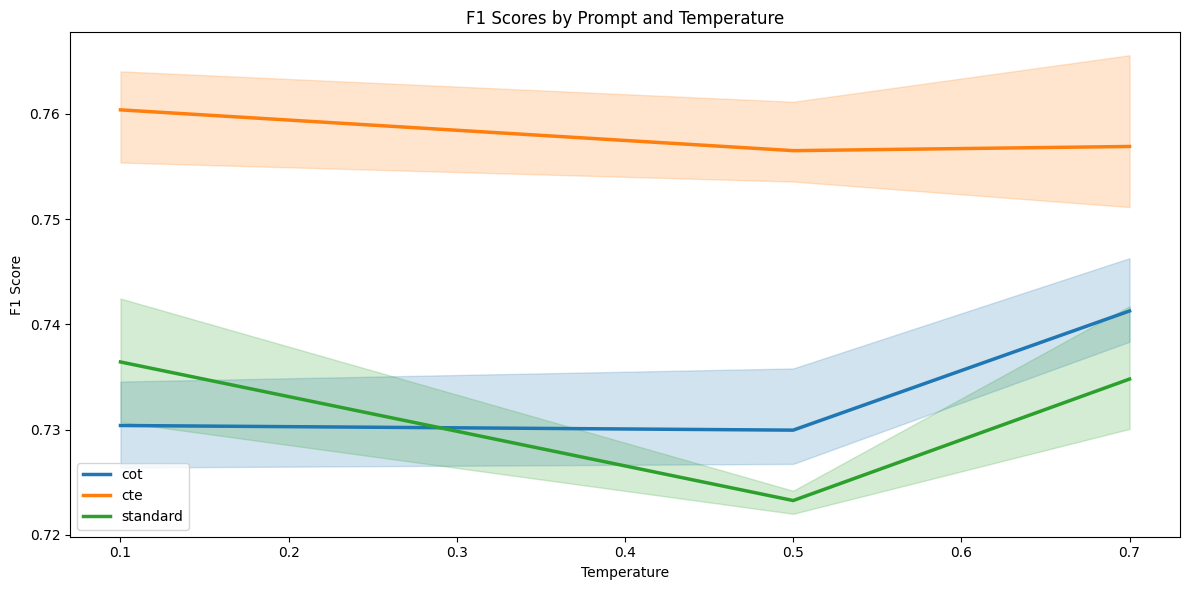

In [61]:
plot_variance(prepared_df)

## Inspect

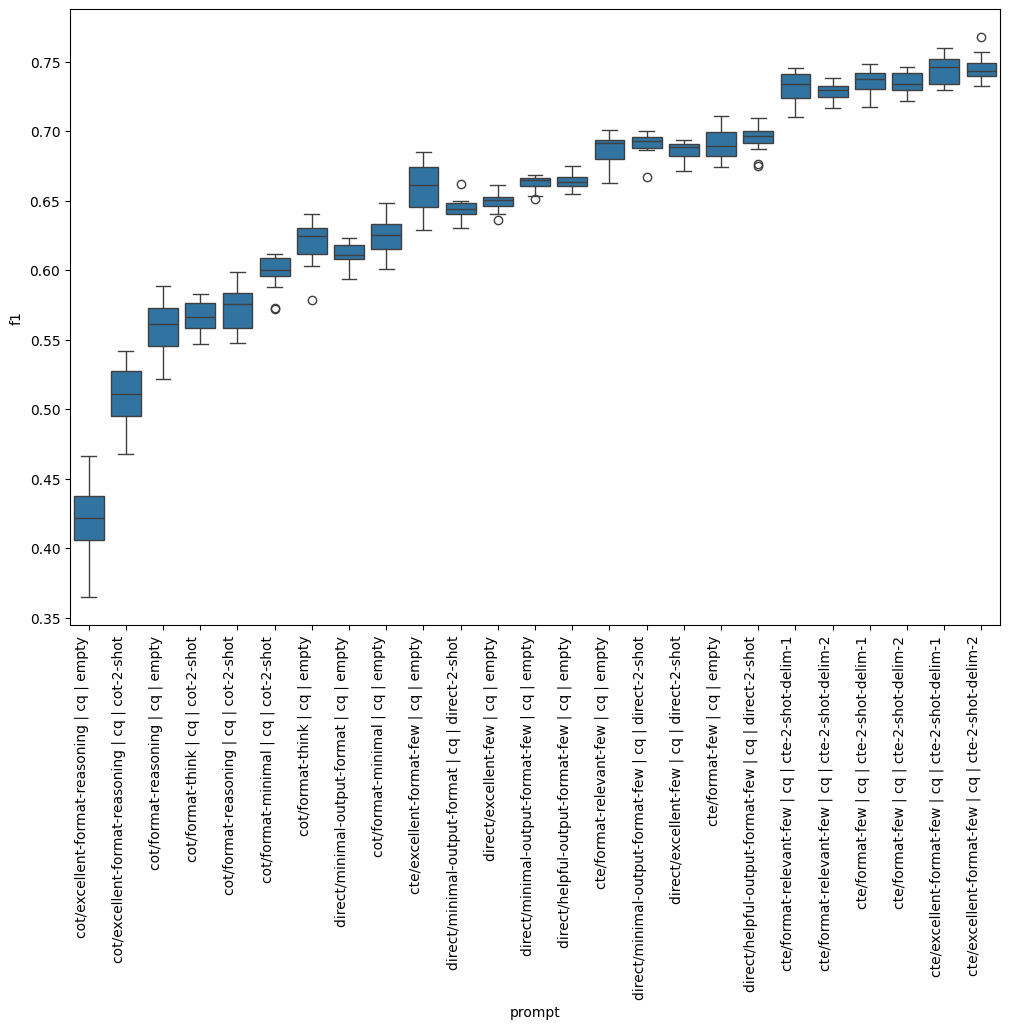

In [ ]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=90, ha="right");